# Introduction to the Pulse Sequence: Exciting atoms in the Rydberg state

In [1]:
import numpy as np
import pulser
from pprint import pprint
import pulser_simulation

The `Sequence` is the core object in Pulser. It enables the manipulation of the state of the atoms by controlling their configuration in the `Register` and the application of `Pulses`. This tutorial illustrates the page [Quantum Computing with Neutral Atoms](https://pulser.readthedocs.io/en/stable/review.html). It shows the step-by-step creation of a simple Pulser Sequence that excites all the atoms to the Rydberg state, and how to simulate it using `pulser-simulation`.

## 1. Creating the `Register`

The `Register` defines the positions of the atoms and their associated names. There are multiple ways of defining a `Register`:

-  From a dictionary that associates a name (the key) to a cooordinate (the value): this is the most customizable one, but can be quite complex to use when working with many atoms.
-  From a list of coordinates: the naming happens automatically using the list's order and a common prefix that can be added before each number. It can also automatically center the entire array around the origin. This is useful when you know exactly where you want the atoms to be placed, but is complex to use if you want the atoms to follow a pattern.
- From a built-in class methods to place the atoms following a common array pattern, like square lattices or triangular lattices.
- From a `RegisterLayout`, a layout of traps used preliminary to the `Sequence` to trap atoms before redistributing them into the sites of the `Register`. This is used in some real QPUs that don't allow the definition of `Register` without using a calibrated layout.
- From a `MappableRegister`, an abstract `Register` that only stores names without coordinates.

All these options are further detailed in the [Register section](https://pulser.readthedocs.io/en/stable/tutorials/reg_layouts.html). Let's here focus on the easiest option, the 3rd one, to create a Register of 4 atoms placed in a square far from each other.

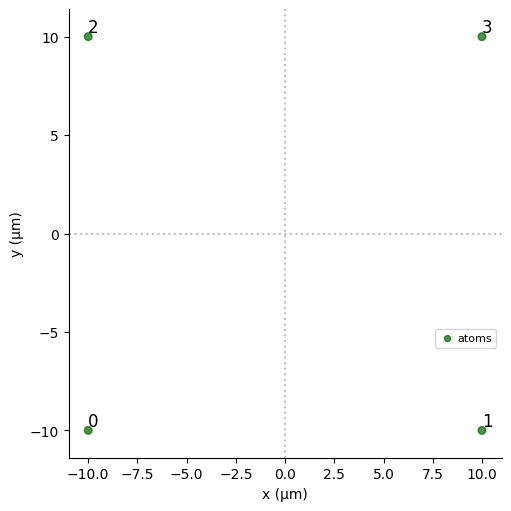

In [2]:
reg = pulser.Register.square(
    2, spacing=20
)  # 2x2 array with atoms placed at 20 um apart
reg.draw()

## 2. Initializing the Sequence

To create a `Sequence`, one has to provide it with the `Register` instance and the `Device` in which the sequence will be executed. A `Device` object stores all the physical constraint the `Sequence` has to match. It will first check that the `Register` is valid, and will be used to validate each `Pulse` that will be added to the `Sequence`.

Pulser provides some examples of `Device` in `pulser.devices` (find the list of these examples [in the API](https://pulser.readthedocs.io/en/stable/apidoc/core.html#physical-devices)). For simulation purposes, specific devices having less physical constraints can be used, named `VirtualDevice`. A detail description of `Device` and `VirtualDevice` is presented [in this tutorial](https://pulser.readthedocs.io/en/stable/tutorials/virtual_devices.html).

Each QPU has an associated `Device`. The available devices can be fetched using a `RemoteConnection`. Have a look to [the page on QPU Backend](https://pulser.readthedocs.io/en/stable/tutorials/backends.html) to see how to fetch the `Device` associated with the QPU.

Let's build our `Sequence` with the `Register` previously defined and the device `AnalogDevice` from `pulser.devices`. `AnalogDevice` is an example of the first generation of QPU developed at Pasqal:

In [3]:
from pulser.devices import AnalogDevice

seq = pulser.Sequence(reg, AnalogDevice)

## 3. Declaring a Channel

A `Device` implements some `Channels`, that can be used to modify the state of the atoms via the application of `Pulses`. As presented in the [conventions page](https://pulser.readthedocs.io/en/stable/conventions.html), each channel implements a different Hamiltonian.

The `AnalogDevice` has only one `Channel`, a `Rydberg.Global` channel that can be used to perform the same single-qubit operation on all the atoms using the rydberg states.
Other channels can be used, and are present in `DigitalAnalogDevice` or in `MockDevice`:
    - The `EOM` in a `Rydberg Channel` can be used to perform the same operations, but faster.
    - The `DMM` channel can be used to perform local `Z` operations on the qubits.
    - The `Raman` channel can be used to perform digital operations via the use of hyperfine ground states.
    - The `Microwave` channel can be used to perform analog operations with a different interaction term (only in `MockDevice`).

At the beginning of the `Sequence`, all the channels of the `Device` are availble:

In [4]:
seq.available_channels

{'rydberg_global': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 12.566370614359172 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 100000000 ns, Modulation Bandwidth: 8 MHz, Basis: 'ground-rydberg')}

We can see that we only have the `Rydberg.Global` channel available. To be used in the `Sequence`, we have to declare the channel and provide it a name. Note how a declared channel is no longer reported as available.

In [5]:
seq.declare_channel("ch0", "rydberg_global")
print("Available channels after declaring 'ch0':")
pprint(seq.available_channels)

Available channels after declaring 'ch0':
{}


At any time, we can also consult which channels were declared, their specifications and the name they were given by calling:

In [6]:
seq.declared_channels

{'ch0': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 12.566370614359172 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 100000000 ns, Modulation Bandwidth: 8 MHz, Basis: 'ground-rydberg')}

## 4. Adding a Pulse

Now that we have declared a `Channel`, we can add `Pulses` to this channel. `Pulses` are defined by three quantities: the amplitude $\Omega$ (in rad/µs), the detuning $\delta$ (in rad/µs) and the phase $\phi$ (in rad).

With Pulser, we can define the value of the amplitude and detuning at each nanosecond using `Waveforms`, while the phase is constant within each pulse. The detuning and the phase define the global phase of a signal. If you want a time-dependent global phase, it is possible to define it directly with a [`Pulse.ArbitraryPhase`](https://pulser.readthedocs.io/en/stable/apidoc/core.html#pulser.pulse.Pulse.ArbitraryPhase) (presented in [a specific tutorial](nopageatthemoment)).

The `Pulses` that we are applying are defining the Drive Hamiltonian, that performs local operations on each atoms. Each atom sees the local operator:
$$H^D(t) / \hbar = \frac{\Omega(t)}{2} \cos(\phi) \hat{\sigma}^x  - \frac{\Omega(t)}{2} \sin(\phi) \hat{\sigma}^y  - \frac{\delta(t)}{2} \hat{\sigma}^z$$


Let's program a Pulse that excites the atom in the Rydberg state. As described in the Annex at the bottom of the page, a `Pulse` with $\phi=0$, $\delta(t)=0$ and $\int_0^{\Delta t} \Omega(u) du = \pi$ will perform just that.

There are many ways to implement a `Pulse`:

- Provide separate `Waveforms` for the amplitude and detuning, as well as a constant phase: this is the most customizable way. 
- Use a built-in class function that automatically generates some `Waveforms` (see all these functions [in the API](https://pulser.readthedocs.io/en/stable/apidoc/core.html#module-pulser.pulse)).

In our case, since the detuning is constant, we will use the built-in class method `pulser.Pulse.ConstantDetuning`. We could also have provided a `ConstantWaveform`.

There are also many ways to define the `Waveform` for the amplitude:

- We can define the value of the `Waveform` at each nanosecond by providing an array to `CustomWaveform` (knowing the integral of the defined waveform is $\pi$).
- We can use one of the many built-in `Waveform` functions, available [in the `pulser.waveforms` module](https://pulser.readthedocs.io/en/stable/apidoc/core.html#module-pulser.waveforms). Some are being defined by their area under the curve such as the [`BlackmanWaveform`](https://pulser.readthedocs.io/en/stable/apidoc/core.html#pulser.waveforms.BlackmanWaveform). Some `Waveforms` are further explained in some tutorials, like the [InterpolatedWaveforms](https://pulser.readthedocs.io/en/stable/tutorials/interpolated_wfs.html) or the [CompositeWaveforms](https://pulser.readthedocs.io/en/stable/tutorials/composite_wfs.html). 



Integral of the waveform is: 3.141592653589794


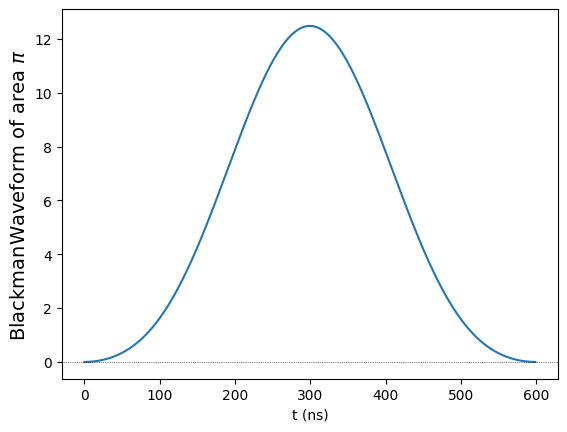

In [7]:
pi_wvf = pulser.BlackmanWaveform(600, np.pi)
print("Integral of the waveform is:", pi_wvf.integral)
pi_wvf.draw(ylabel="BlackmanWaveform of area $\\pi$")
pi_pulse = pulser.Pulse.ConstantDetuning(pi_wvf, 0, 0)

Let's add this pulse to `'ch0'`:

In [8]:
seq.add(pi_pulse, "ch0")

Let's check the schedule to see how this is looking:

In [9]:
print(seq)

Channel: ch0
t: 0 | Initial targets: 0, 1, 2, 3 | Phase Reference: 0.0 
t: 0->600 | Pulse(Amp=Blackman(Area: 3.14) rad/µs, Detuning=0 rad/µs, Phase=0) | Targets: 0, 1, 2, 3




We can also draw the sequence, for a more visual representation:

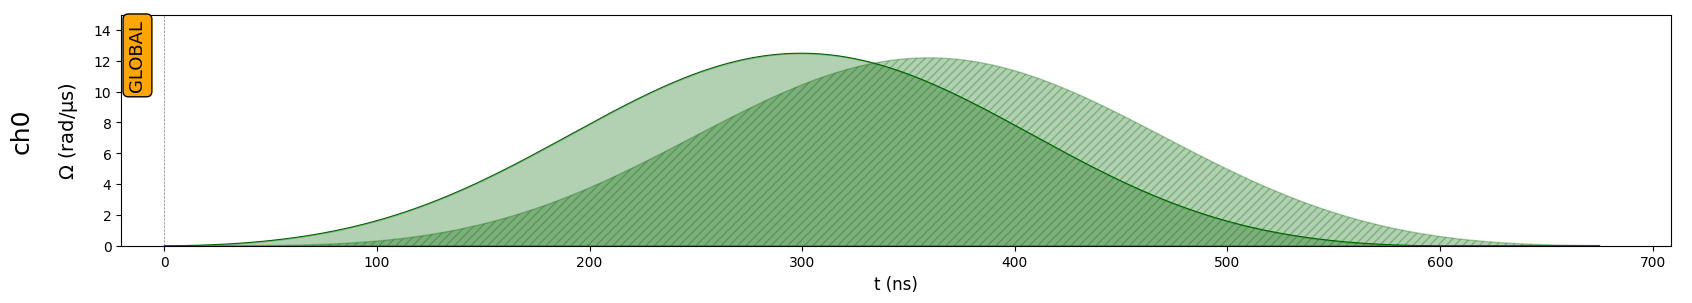

In [10]:
seq.draw()

After this, you could add multiple `Pulses` to this channel, or define other channels to target other transitions. But let's move on to the final step: the measurement.

## 5. Measurement

To finish a sequence, we measure it. A measurement signals the end of a sequence, so after it no more changes are possible. We can measure a sequence by calling:

In [11]:
seq.measure(basis="ground-rydberg")

When measuring, one has to select the desired measurement basis. The availabe options depend on the device and can be consulted by calling:

In [12]:
AnalogDevice.supported_bases

{'ground-rydberg'}

`AnalogDevice` supports only one basis since it only has one channel. However, `DigitalAnalogDevice` for instance also supports the `digital` basis. An example of a `Sequence` using different measurement basis is provided in [another tutorial](dontexistyet).

We've now obtained the final sequence!

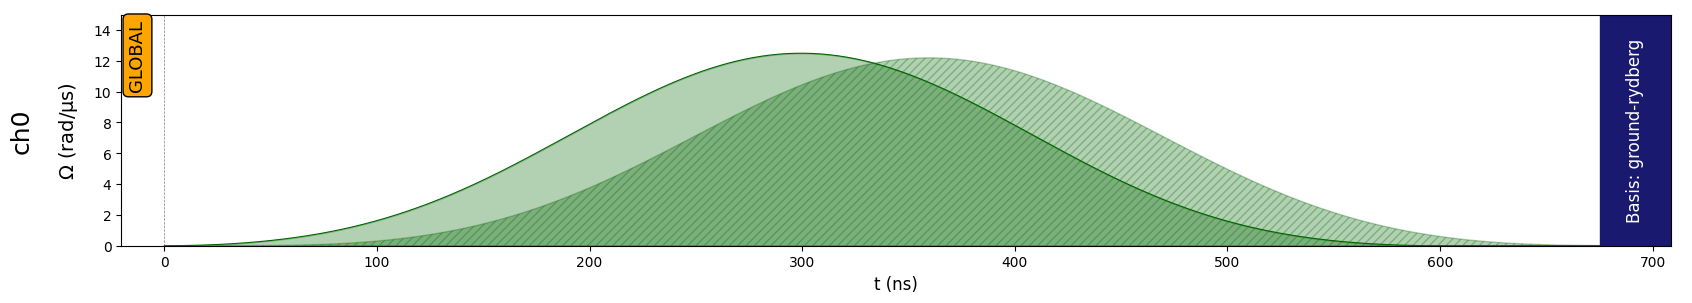

In [13]:
seq.draw()

## 6. Submit the `Sequence` to a `Backend`

We have tailored the `Pulse` such that the atoms all go from the ground state (measurement outcome: 0) to the excited state (measurement outcome: 1) (see the [Measurement section in the "Conventions" page](https://pulser.readthedocs.io/en/stable/conventions.html#state-preparation-and-measurement)). But is it really happening ? The `Sequence` can be simulated using a [`Backend`](https://pulser.readthedocs.io/en/stable/apidoc/backend.html), a common interface for execution of Sequence using the QPU and an emulator.

Prior to submitting the `Sequence` to the QPU, it is of good practice (if the number of atoms is not too big) to use an emulator to simulate the outcome of the Sequence. A list of all the available emulators is given [in the API](https://pulser.readthedocs.io/en/stable/apidoc/backend.html). Let's start with emulating the `Sequence` locally.

Pulser comes with `pulser-simulation`, a package to simulate pulser `Sequence` using the python library [**QuTip**](https://qutip.org/). It implements the `QutipBackend` class, a `Backend` that can be initialized with a `Sequence`. The simulation in itself is performed when calling the method `run`. It solves the Schrödinger equation associated with the Ising Hamiltonian (see the Annex below) using QuTip solvers, and returns a [`SimulationResults`](https://pulser.readthedocs.io/en/stable/apidoc/simulation.html#simulation-results) object.

This `SimulationResults` object can be of two kinds:
- A `NoisyResult` if the simulation involves some kinds of noise: the result can only be returned as the statistics of multiple measurements outcome.
- A `CoherentResult` in the other cases: the result can be described by an array representing the state. It can also be be returned as the statistics of multiple measurements outcome.

Since we are not performing simulation involving noise here, we get a `CoherentResult`. An array representing the final state of the system of 4 atoms can be obtained with `CoherentResult.get_final_state`:


In [14]:
sim = pulser_simulation.QutipBackend(seq)
res = sim.run()
res.get_final_state()

Quantum object: dims = [[2, 2, 2, 2], [1, 1, 1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 9.99995239e-01+0.00000000e+00j]
 [-1.46345420e-03-6.18280356e-07j]
 [-1.46345420e-03-6.18280356e-07j]
 [-2.34286748e-05+4.86193759e-04j]
 [-1.46345420e-03-6.18280356e-07j]
 [-2.34286748e-05+4.86193759e-04j]
 [-1.81993889e-05+6.05963602e-05j]
 [ 4.11724561e-08+3.10818967e-06j]
 [-1.46345420e-03-6.18280356e-07j]
 [-1.81993889e-05+6.05963602e-05j]
 [-2.34286748e-05+4.86193759e-04j]
 [ 4.11724561e-08+3.10818967e-06j]
 [-2.34286748e-05+4.86193759e-04j]
 [ 4.11724561e-08+3.10818967e-06j]
 [ 4.11724561e-08+3.10818967e-06j]
 [-4.71483183e-07-6.73398629e-08j]]

The final state is close to the state where all the atoms are in the excited state, defined by:
$$\left|rrrr\right> = (1, 0)\otimes (1, 0) \otimes (1, 0) \otimes (1, 0) = (1, 0, ..., 0)$$
(see the [convention page](https://pulser.readthedocs.io/en/stable/conventions.html) for details). The small differences between the obtained final state and the targeted one are due to the interactions between the atoms, that will be studied the notebook on [Rydberg blockade](https://pulser.readthedocs.io/en/stable/tutorials/sequence/rydberg_blockade.html).

These differences are so small that, when measuring the `Sequence` 1000 times, the system is always found in the $\left|rrrr\right>$ state:

In [15]:
res.sample_final_state(N_samples=1000)

Counter({'1111': 1000})

In all the measurement outcomes, all the atoms are measured in the '1' state. This means they are all always measured in the excited state: the `Sequence` works as intended !

## Follow up

- To further study the influence of an amplitude Pulse on the state of the atoms, and discover how to program a `Sequence` with a variable parameter, you can have a look at the notebook on Parametrized Sequences and its Rabi experiment use-case.

- In this `Sequence`, only the amplitude waveform of the `Pulse` was tailored to program a RX gate. It is possible to tailor complex 1-qubit gates using amplitude and detuning at the same time. This is presented in an advanced notebook, where [we tailor a Hadamard gate and perform virtual Z-rotations](https://pulser.readthedocs.io/en/stable/tutorials/phase_shifts_vz_gates.html).

- In this `Sequence`, the atoms were placed very far from each other, such that the interactions between them were negligeable. The interaction between the atoms is of importance to, for instance, program an anti-ferromagnetic state, solve an optimization problem such as Mutually Independent Set (MIS), or program a CZ gate for digital quantum computing. This interaction is associated with a phenomenon named Rydberg blockade, a small study on this phenomenon is presented here.

- The `Sequence` created here uses a `Rydberg.Global` channel, with global addressability. To perform local operations on the qubits, it is possible to use the `DMM` channel or `Rydberg` and `Raman` channels with local addressability. We present in this notebook the preparation of an initial state different from $\left| gggg\right>$ using a `DMM` and `local` channels.

- The `Sequence` presented here only involved one `Channel`, the `Rydberg Channel`, and one `Pulse`. When working with multiple channels, the "protocol" with which we add the Pulses matter. This is described in another tutorial, where we program a `Sequence` using both a `Raman` and a `Rydberg` channel.

- The same `Sequence` could have been created with a `MockDevice` instead of an `AnalogDevice` and by declaring a `Raman.Global` or a `Microwave.Global` channel instead of the `Rydberg.Global` channel. The effect on the state of the atom would have been the same: they would have ended up in an excited state when coming from a ground state.  

## Annex: Computing the effect of a Rydberg Pulse on the state of the atoms

### Evolution of a system under an Hamiltonian

The evolution of the state of the system of atoms $\left| \psi \right>(t)$ under an Hamiltonian $H$ is given by the Schrödinger equation:

$$ i \hbar \frac{d\left| \psi(t) \right>}{dt} = H(t)\left| \psi(t) \right>$$

Knowing the initial state at time $t=0$, the state at time $\Delta t$ is given by $e^{-\frac{i}{\hbar} \int_0^{\Delta t} H(u) du}\left| \psi(0) \right>$. $e^{-\frac{i}{\hbar} \int_0^{\Delta t} H(u) du}$ is named the evolution operator.

### Application to the Drive Hamiltonian

In this case, we placed ourselves in a specific case where the distance between the atoms in the Register is very far. Therefore the interaction between them is very small and the interaction Hamiltonian can be neglected compared to the drive Hamiltonian: we have $H \approx H^D$.

Then, the effect of a `Pulse` of duration $\Delta t$ on the state of the atom is given by the evolution operator 
$$ e^{-\frac{i}{\hbar} \int_0^{\Delta t} H^D(u) du} = \exp\left(-i\left(\frac{\int_0^{\Delta t} \Omega(u) du}{2} \cos(\phi) \hat{\sigma}^x  - \frac{\int_0^{\Delta t} \Omega(u) du}{2} \sin(\phi) \hat{\sigma}^y  - \frac{\int_0^{\Delta t} \delta(u) du}{2} \hat{\sigma}^z\right)\right) $$
Conclusion: What really matters in the operation is the integral of $\Omega$ and $\delta$ along time.

### Tailoring a Pauli X rotation

Initially, the atoms are all in the ground state, such that $\left | \psi(0) \right> = \left |gggg\right>$. To excite the atoms to the state $\left |rrrr\right>$, we have to make an operation involving only the $\hat{\sigma}^x$ operator. This can clearly be seen on the Bloch sphere representation for instance.

This dictates that $\sin(\phi) = 0$ and $\frac{\int_0^{\Delta t} \delta(u) du}{2}=0$. The easiest solution is to have $\phi=0$ and $\delta(t)=0$.

With these conditions, the evolution operator applied on each atom is given by $\exp\left(-i\left(\frac{\int_0^{\Delta t} \Omega(u) du}{2}\hat{\sigma}^x\right)\right)$.

### Computing the effect of a Pauli X rotation on the state of the atom

A well-known formula for Pauli operators ($\hat{\sigma} \in \{\hat{\sigma}^x, \hat{\sigma}^y, \hat{\sigma}^z\}$) is:
$$\exp\left(i \theta \hat{\sigma}\right) = \cos(\theta) I + i \sin(\theta) \hat{\sigma} $$

Therefore, $\exp\left(-i\left(\frac{\int_0^{\Delta t} \Omega(u) du}{2}\hat{\sigma}^x\right)\right) = \cos\left(\frac{\int_0^{\Delta t} \Omega(u) du}{2}\right) I - i \sin\left(\frac{\int_0^{\Delta t} \Omega(u) du}{2}\right)\hat{\sigma}^x$

The final state is then given by 
$$\psi(\Delta t) = \cos\left(\frac{\int_0^{\Delta t} \Omega(u) du}{2}\right) \left|\psi(0)\right> - i \sin\left(\frac{\int_0^{\Delta t} \Omega(u) du}{2}\right)\hat{\sigma}^x\left|\psi(0)\right> \\
= \cos\left(\frac{\int_0^{\Delta t} \Omega(u) du}{2}\right) \left|gggg\right> - i \sin\left(\frac{\int_0^{\Delta t} \Omega(u) du}{2}\right)\left|rrrr\right>$$

As a conclusion, if we want the final state $\left|\psi(\Delta t)\right>$ to be $\left | rrrr\right>$, it is necessary that $\frac{\int_0^{\Delta t} \Omega(u) du}{2} = \frac{\pi}{2}\implies\int_0^{\Delta t} \Omega(u) du = \pi$: the `Pulse` in this case is what we call a $\pi$-pulse, a Pulse whose amplitude is of area $\pi$.